In [1]:
import keras
from keras import layers
from keras import ops

import math
import numpy as np
import pandas as pd
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from functools import partial

2025-11-06 21:06:27.436741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762459587.448349   32116 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762459587.451903   32116 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762459587.462847   32116 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762459587.462858   32116 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762459587.462859   32116 computation_placer.cc:177] computation placer alr

In [2]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [3]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

In [4]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [5]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [6]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 50
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [7]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, nor expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 0.
    lookup = layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup


def encode_categorical(batch_x, batch_y, weights):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = lookup_dict[feature_name](batch_x[feature_name])

    return batch_x, batch_y, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = (
        tf_data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size=batch_size,
            column_names=CSV_HEADER,
            column_defaults=COLUMN_DEFAULTS,
            label_name=TARGET_FEATURE_NAME,
            num_epochs=1,
            header=False,
            na_value="?",
            shuffle=shuffle,
        )
        .map(prepare_example, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()

I0000 00:00:1762459611.135226   32116 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8809 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [8]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [9]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
    return inputs

In [10]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.

            # Convert the string input values into integer indices.

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [11]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

Total model weights: 110693


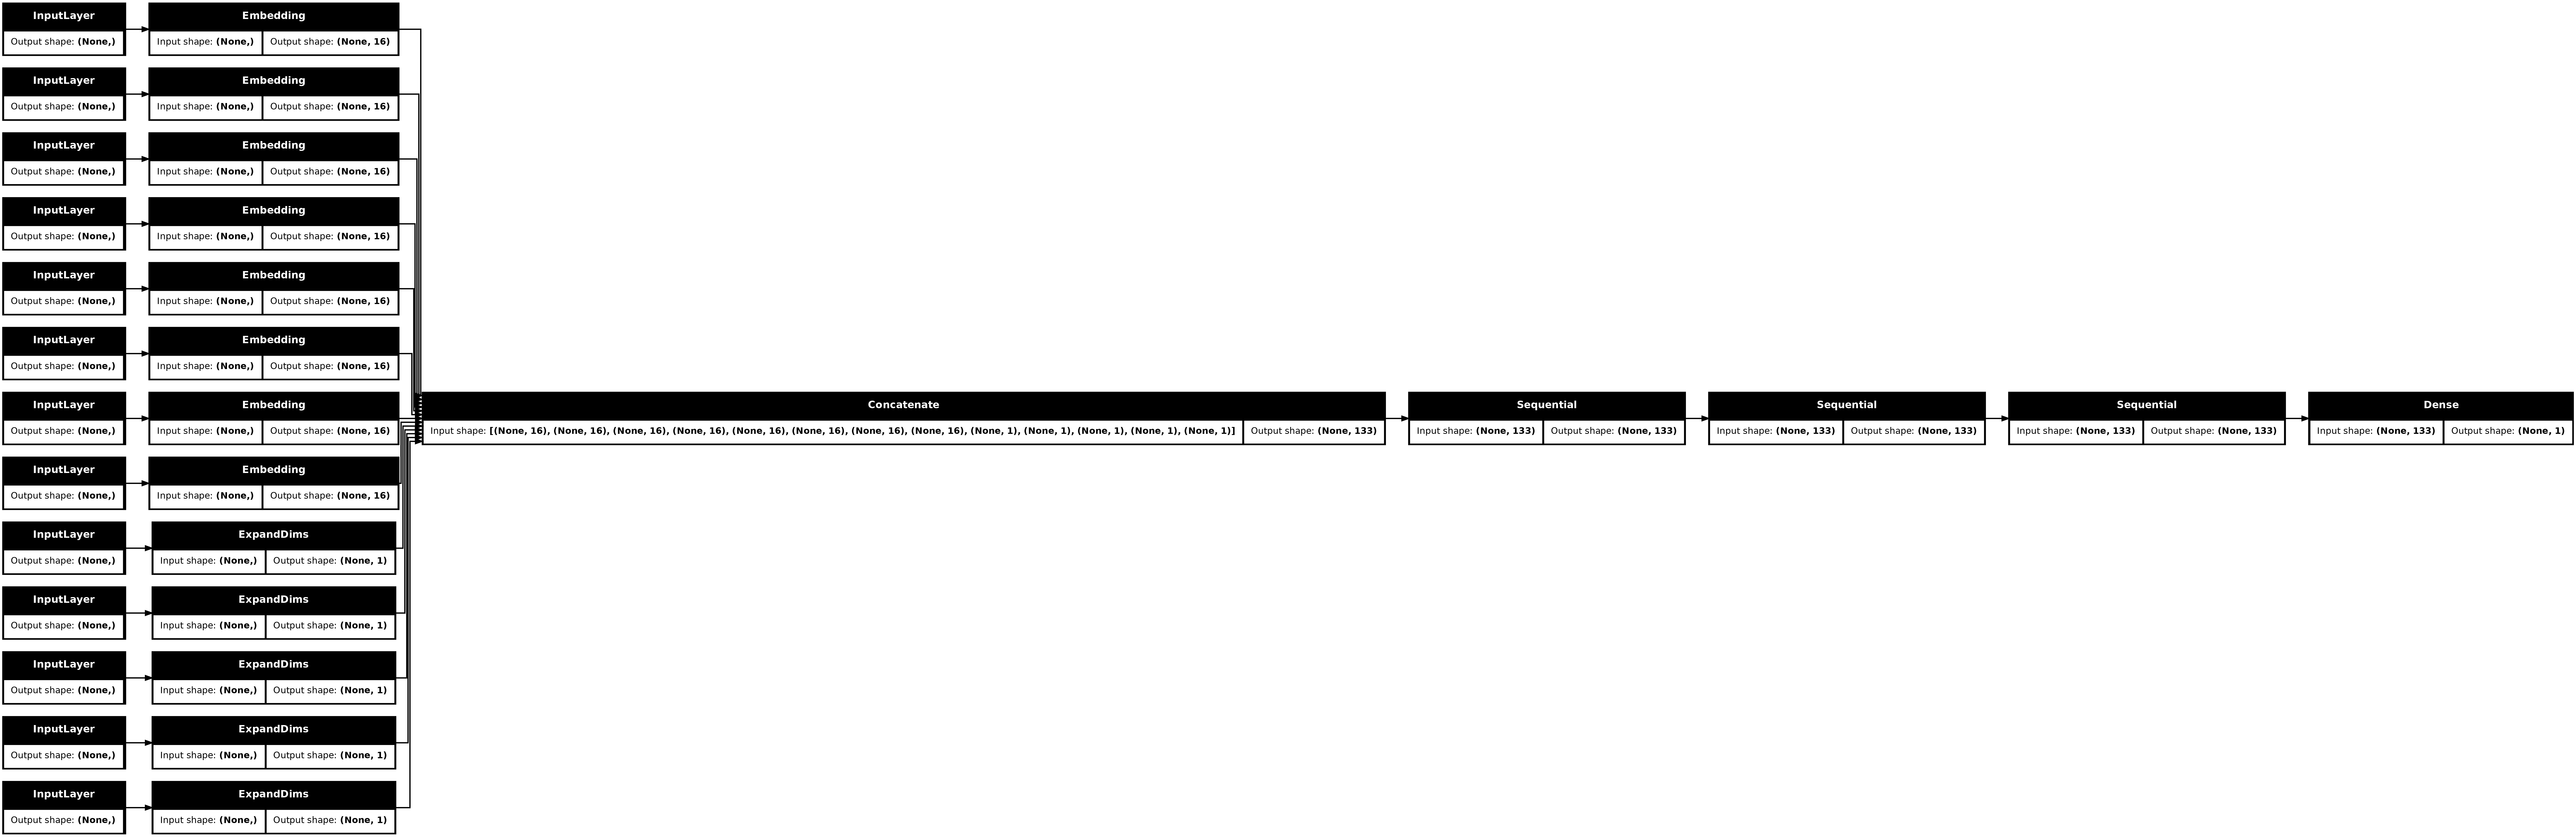

In [12]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [13]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15


I0000 00:00:1762459615.413663   32278 service.cc:152] XLA service 0x79f8700069e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762459615.413677   32278 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-06 21:06:55.479596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762459615.803606   32278 cuda_dnn.cc:529] Loaded cuDNN version 91002


     97/Unknown 5s 2ms/step - accuracy: 0.6263 - loss: 141589.5137

I0000 00:00:1762459617.838356   32278 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    652/Unknown 8s 5ms/step - accuracy: 0.6927 - loss: 116577.9416

2025-11-06 21:07:01.026067: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-11-06 21:07:01.026082: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2025-11-06 21:07:01.026088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:01.026091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:01.026095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:01.026098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-

652/652 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7280 - loss: 102782.1562 - val_accuracy: 0.8090 - val_loss: 76714.8203
Epoch 2/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 80997.0809

2025-11-06 21:07:02.284113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:02.284128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:02.284133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:02.284137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:02.284141: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_14]]
2025-11-06 21:07:02.284151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:02.284155: I tensorflow/c

649/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 80549.4454

2025-11-06 21:07:03.318631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:03.318643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:03.318646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:03.318649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:03.318652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15422526404393832186
2025-11-06 21:07:03.318654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:03.318656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8011 - loss: 77495.3750 - val_accuracy: 0.8237 - val_loss: 68077.8359
Epoch 3/15
 99/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 69524.7131

2025-11-06 21:07:03.688056: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


629/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 70925.9172

2025-11-06 21:07:04.694063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:04.694076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:04.694079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:04.694082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:04.694085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:04.694087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:04.694089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8191 - loss: 70518.9609 - val_accuracy: 0.8323 - val_loss: 65267.1523
Epoch 4/15
 99/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8081 - loss: 68218.5565

2025-11-06 21:07:05.062444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:05.062457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:05.062461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:05.062464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:05.062467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:05.062471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:05.062474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

624/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 69136.8928

2025-11-06 21:07:06.077015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:06.077028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:06.077033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:06.077036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:06.077038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:06.077042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:06.077045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8234 - loss: 68926.8594 - val_accuracy: 0.8349 - val_loss: 65831.2188
Epoch 5/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8245 - loss: 66179.5906

2025-11-06 21:07:06.436629: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-11-06 21:07:06.436643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:06.436647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:06.436650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:06.436653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:06.436655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:06.436662: I tensorflow/

643/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8254 - loss: 67952.8038

2025-11-06 21:07:07.471881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:07.471895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:07.471900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:07.471903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:07.471908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15422526404393832186
2025-11-06 21:07:07.471911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:07.471914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8254 - loss: 68193.3359 - val_accuracy: 0.8367 - val_loss: 64668.2891
Epoch 6/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8241 - loss: 65922.4947

2025-11-06 21:07:07.840256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:07.840270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:07.840274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:07.840277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:07.840282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885


649/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 67684.9037

2025-11-06 21:07:08.869396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:08.869409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:08.869413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:08.869416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:08.869420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15422526404393832186
2025-11-06 21:07:08.869423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:08.869426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8270 - loss: 67749.6641 - val_accuracy: 0.8357 - val_loss: 64329.7344
Epoch 7/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8174 - loss: 65208.7572

2025-11-06 21:07:09.235120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:09.235132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:09.235136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:09.235139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:09.235142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:09.235148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


621/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8236 - loss: 67263.5020

2025-11-06 21:07:10.253843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:10.253857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202
2025-11-06 21:07:10.253862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2788094540302162914
2025-11-06 21:07:10.253866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17130933584368834380
2025-11-06 21:07:10.253873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:10.253881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:10.253885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8258 - loss: 67491.8438 - val_accuracy: 0.8359 - val_loss: 63982.7109
Epoch 8/15
 98/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8154 - loss: 65110.1095

2025-11-06 21:07:10.614870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:10.614883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:10.614885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:10.614895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:10.614899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:10.614902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:10.614904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

625/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 66725.3816

2025-11-06 21:07:11.627607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:11.627621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:11.627629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8279 - loss: 67046.3125 - val_accuracy: 0.8378 - val_loss: 64365.4414
Epoch 9/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8138 - loss: 64702.3692

2025-11-06 21:07:11.983252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-11-06 21:07:11.983267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:11.983272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:11.983276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:11.983280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:11.983284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:11.983289: I tensorflow/

652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 66555.0236

2025-11-06 21:07:13.006214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:13.006227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:13.006232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:13.006235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:13.006239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:13.006241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202
2025-11-06 21:07:13.006244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8285 - loss: 66943.1484 - val_accuracy: 0.8355 - val_loss: 64587.4805
Epoch 10/15
 97/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 64606.4329

2025-11-06 21:07:13.375704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:13.375715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:13.375718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:13.375721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:13.375723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:13.375728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


649/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8259 - loss: 66284.1151

2025-11-06 21:07:14.407879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:14.407892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:14.407896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8280 - loss: 66720.8516 - val_accuracy: 0.8379 - val_loss: 64419.1641
Epoch 11/15
649/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8274 - loss: 66058.2269

2025-11-06 21:07:15.800667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:15.800680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:15.800684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:15.800687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:15.800692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:15.800695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:15.800697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8288 - loss: 66400.4141 - val_accuracy: 0.8376 - val_loss: 63575.3086
Epoch 12/15
 99/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8233 - loss: 64281.4732

2025-11-06 21:07:16.163340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:16.163352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:16.163356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:16.163362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8295 - loss: 66267.6406 - val_accuracy: 0.8392 - val_loss: 63945.8398
Epoch 13/15
 99/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 63851.6079

2025-11-06 21:07:17.566579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:17.566595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:17.566599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:17.566603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:17.566605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:17.566607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:17.566610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

625/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8286 - loss: 65764.7010

2025-11-06 21:07:18.581080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:18.581095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:18.581103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:18.581113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8307 - loss: 66110.8672 - val_accuracy: 0.8380 - val_loss: 63702.3359
Epoch 14/15
101/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8245 - loss: 63991.8350

2025-11-06 21:07:18.938544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:18.938553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:18.938557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:18.938559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:18.938565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885


632/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 65784.1269

2025-11-06 21:07:19.936324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:19.936335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:19.936340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:19.936343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202
2025-11-06 21:07:19.936345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17130933584368834380


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8295 - loss: 66318.3594 - val_accuracy: 0.8365 - val_loss: 64439.0820
Epoch 15/15
102/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - loss: 64073.5477

2025-11-06 21:07:20.299266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:20.299278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:20.299282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:20.299285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:20.299288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17614351629202914885
2025-11-06 21:07:20.299294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


633/652 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8268 - loss: 65791.0233

2025-11-06 21:07:21.305293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:21.305307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:21.305311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:21.305314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:21.305318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15422526404393832186
2025-11-06 21:07:21.305321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:21.305323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8291 - loss: 66116.5859 - val_accuracy: 0.8351 - val_loss: 64463.2930


2025-11-06 21:07:21.671366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:21.671378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:21.671382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:21.671384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:21.671392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:21.671393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7188680292722312202
2025-11-06 21:07:21.671395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

Model training finished
Validation accuracy: 83.51%


2025-11-06 21:07:22.039986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:22.039998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10000633219875391931
2025-11-06 21:07:22.040001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:22.040011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:22.040015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:22.040018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13462276767390303831
2025-11-06 21:07:22.040020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

In [14]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Total model weights: 88543


In [15]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    652/Unknown 16s 9ms/step - accuracy: 0.7388 - loss: 103744.0808

2025-11-06 21:07:41.108865: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2025-11-06 21:07:41.108880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:41.108884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:41.108888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:41.108891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:41.108895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:41.108898: I tensorflow/core

652/652 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7688 - loss: 92928.9531 - val_accuracy: 0.7851 - val_loss: 128970.5078
Epoch 2/15
 54/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7863 - loss: 82806.2944

2025-11-06 21:07:43.225375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:43.225390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:43.225396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:43.225404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:43.225409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:43.225414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:43.225418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

641/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7942 - loss: 82507.1088

2025-11-06 21:07:44.961330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:44.961345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:44.961349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:44.961352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:44.961356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:44.961358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7971 - loss: 81078.3750 - val_accuracy: 0.8091 - val_loss: 75330.6953
Epoch 3/15
 61/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8091 - loss: 78372.3974

2025-11-06 21:07:45.380560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


643/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 78732.7110

2025-11-06 21:07:47.056203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:47.056216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:47.056220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:47.056222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:47.056226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:47.056228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:47.056231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8053 - loss: 78064.0469 - val_accuracy: 0.8129 - val_loss: 74659.8750
Epoch 4/15
 58/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8121 - loss: 77460.5602

2025-11-06 21:07:47.467670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:47.467685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8078 - loss: 76367.7578 - val_accuracy: 0.8221 - val_loss: 72117.2500
Epoch 5/15
645/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8136 - loss: 75473.6609

2025-11-06 21:07:51.276543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:51.276557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:51.276561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:51.276565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8119 - loss: 74914.0938 - val_accuracy: 0.8146 - val_loss: 75335.9688
Epoch 6/15
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 75127.1045

2025-11-06 21:07:53.393637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:53.393650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:53.393655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:53.393659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:53.393663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:53.393666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8126 - loss: 74286.0938 - val_accuracy: 0.8248 - val_loss: 71718.8281
Epoch 7/15
 57/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8204 - loss: 74810.0455

2025-11-06 21:07:53.801148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:53.801161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:53.801165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:53.801169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:53.801172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:53.801175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:07:53.801177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8170 - loss: 73328.0000 - val_accuracy: 0.8240 - val_loss: 70809.9609
Epoch 8/15
 60/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8213 - loss: 74855.0077

2025-11-06 21:07:55.923963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:55.923977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:55.923982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:55.923985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8168 - loss: 73065.1562 - val_accuracy: 0.8232 - val_loss: 71483.8672
Epoch 9/15
 60/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8230 - loss: 75923.3762

2025-11-06 21:07:58.033308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:58.033321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:58.033324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:58.033328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:58.033330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:07:58.033332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510


636/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8196 - loss: 73269.9172

2025-11-06 21:07:59.725806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:07:59.725821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:07:59.725825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:07:59.725828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:07:59.725832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:07:59.725841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8177 - loss: 72602.4531 - val_accuracy: 0.8264 - val_loss: 69825.3125
Epoch 10/15
650/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8207 - loss: 73313.4601

2025-11-06 21:08:01.789375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:01.789389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:01.789394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:08:01.789398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:01.789403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:01.789407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8193 - loss: 72460.4297 - val_accuracy: 0.8220 - val_loss: 70796.0859
Epoch 11/15
 58/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8234 - loss: 75012.0940

2025-11-06 21:08:02.198351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:02.198364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:02.198369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:02.198375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


650/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8211 - loss: 72827.0890

2025-11-06 21:08:03.906846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:03.906860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:03.906864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:08:03.906867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:03.906871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:03.906874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8194 - loss: 72190.6250 - val_accuracy: 0.8285 - val_loss: 69481.4062
Epoch 12/15
 58/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8240 - loss: 74934.1839

2025-11-06 21:08:04.314998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:04.315012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:04.315016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:04.315019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:04.315022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:08:04.315024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8197 - loss: 71819.6094 - val_accuracy: 0.8291 - val_loss: 68894.2188
Epoch 13/15
 60/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8164 - loss: 75892.5957

2025-11-06 21:08:06.415789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:06.415804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:06.415807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


644/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 72570.3904

2025-11-06 21:08:08.087666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:08.087678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:08:08.087682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:08.087685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8201 - loss: 71613.3828 - val_accuracy: 0.8288 - val_loss: 68631.6172
Epoch 14/15
 60/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8220 - loss: 74758.2490

2025-11-06 21:08:08.510964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:08.510976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:08.510980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:08.510984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:08.510986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:08:08.510988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:08:08.510990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

639/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8206 - loss: 72285.5646

2025-11-06 21:08:10.190074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:10.190088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:10.190093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:08:10.190096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:10.190100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:10.190103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8204 - loss: 71629.4375 - val_accuracy: 0.8283 - val_loss: 68903.5781
Epoch 15/15
 59/652 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8123 - loss: 74699.6752

2025-11-06 21:08:10.595931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:10.595942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:10.595945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:10.595949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:10.595951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:08:10.595954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:08:10.595956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

639/652 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8206 - loss: 72162.8682

2025-11-06 21:08:12.274480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:12.274495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:12.274499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 374210381360469635
2025-11-06 21:08:12.274502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:12.274505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:12.274508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8217 - loss: 71253.8750 - val_accuracy: 0.8285 - val_loss: 68882.0234
Model training finished
Validation accuracy: 82.85%


2025-11-06 21:08:13.105177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7000892632454707649
2025-11-06 21:08:13.105190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9098103353006670113
2025-11-06 21:08:13.105193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13780150025259286399
2025-11-06 21:08:13.105197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6295171311298339116
2025-11-06 21:08:13.105199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17622258956162349728
2025-11-06 21:08:13.105202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4940264878332396510
2025-11-06 21:08:13.105204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i